# Step 5: Recommender System

To implement the image recommendation functionality for our project, we are following these steps:

1. Image Classification: Utilize our existing machine learning model to classify the user-provided reference image into one of the eight flower classes.
2. Similarity Detection:
    - Construct a Convolutional Neural Network (CNN) to extract feature vectors from images
    - For each image in our database use this CNN to extract its feature vector, then store it in `./data/recommender-database.csv`, to allow for efficient retrieval during the recommendation process.
    - Use the same CNN to extract a feature vector from our the user-provided reference image.
    - Apply a K-Means unsupervised machine learning model to cluster the reference image's feature vector with those of the images in our database. We select the number of cluster $k$ dynamically using the number of images need to be recommended.
3. Recommending Images: Once we have the clusters, we would recommend images from the cluster that the reference image belongs to. To do this accurately, we are using [Scikit-learn implementation of cosine similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to find the most similar images to the reference image within that cluster.

In [2]:
# Imports and environmental setups

import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import joblib


# Custom utils functions
from utils import dataset
from utils import data_manip as manip
from utils.glob import TARGET_IMG_SIZE
from classify import classify


# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
dir_raw_dataset = '../data/raw/'
dir_recommender_database = '../data/recommender-database/'
path_recommender_database = '../data/recommender-database.csv'
dir_models = '../models/'

path_model_clf = '../models/clf-cnn'
model_feature_extractor_name = 'fe-cnn'
path_model_feature_extractor = dir_models + model_feature_extractor_name
model_clustering_name = 'clu-kmeans'
path_model_clustering = dir_models + model_clustering_name + '.model'


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
GPU is NOT AVAILABLE


## 5.1. Feature Extractor - CNN

In [2]:
# Model Parameters
INPUT_DIM = (TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)  # RGB - 3 channels images
FEATURE_VEC_DIM = 16

In [3]:
feature_extractor = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(FEATURE_VEC_DIM),
], name=model_feature_extractor_name)

feature_extractor.compile(optimizer='adam', loss='mse')

In [4]:
feature_extractor.summary()

Model: "fe-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      32832     
                                                                 
 average_pooling2d (AverageP  (None, 61, 61, 64)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 128)               30482

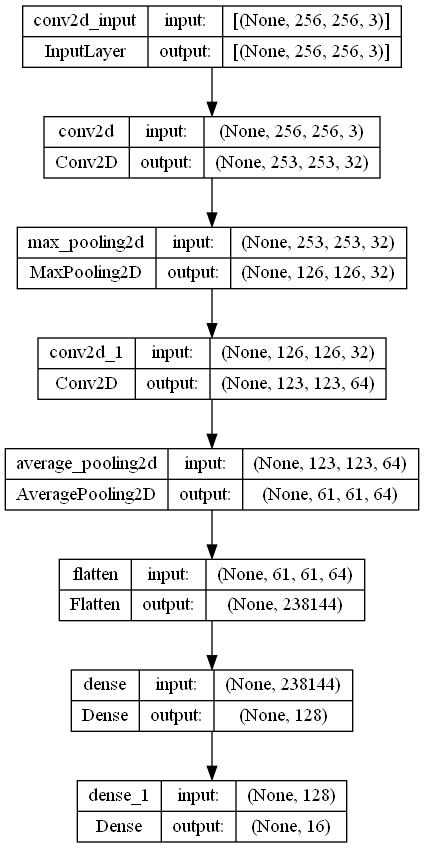

In [5]:
tf.keras.utils.plot_model(feature_extractor, show_shapes=True, to_file=f'images/{model_feature_extractor_name}-Diagram.png')

**Model Export:**

In [6]:
feature_extractor.save(path_model_feature_extractor)

INFO:tensorflow:Assets written to: ../models/fe-cnn\assets


INFO:tensorflow:Assets written to: ../models/fe-cnn\assets


## 5.2. Recommender Database: Feature Extraction

- Load all image in `./data/recommender-database/`.
- Extract their feature vectors using our feature extractor defined above.
- Save them in `./data/recommender-database.csv`

In [7]:
recommendations = {'ImgPath': [], 'Class': []}
for j in range(FEATURE_VEC_DIM):
    recommendations[f'x{j}'] = []

In [8]:
df = dataset.load(dir_recommender_database)
print(f'Number of images in database: {df.shape[0]}')

Number of images in database: 4685


In [9]:
with tqdm(total=len(df), desc='Extracting feature vectors from recommender-database', position=0, leave=True) as pbar:
    for i, row in df.iterrows():
        pbar.update()
        recommendations['ImgPath'].append(row['ImgPath'])
        recommendations['Class'].append(row['Class'])
        with Image.open(f'{dir_recommender_database}{recommendations["ImgPath"][-1]}') as ref:
            ref_processed = manip.resize_crop(ref, TARGET_IMG_SIZE, TARGET_IMG_SIZE)
            ref_processed = manip.normalize_pixels(ref_processed)
            ref_processed = tf.expand_dims(ref_processed, axis=0)

            ref_feature_vector = feature_extractor.predict(ref_processed, verbose=0)
            for j, feature in enumerate(ref_feature_vector.reshape(-1)):
                recommendations[f'x{j}'].append(feature)

Extracting feature vectors from recommender-database:   0%|          | 0/4685 [00:00<?, ?it/s]

In [10]:
df_feature_vectors = pd.DataFrame(recommendations)
df_feature_vectors.to_csv(path_recommender_database, index=False)

## 5.3. Clustering Model

K-Means with K-Means++ initialization and dynamic k selection:

In [11]:
clu = KMeans(init='k-means++', n_init='auto')

**Model Export:**

In [12]:
joblib.dump(clu, path_model_clustering)

['../models/clu-kmeans.model']

## 5.4. Recommendation for Sample Images

We are using 4 random reference images from `./data/raw/`. For each of them, we will determine their class (flower type) and recommend 10 similar images of the same class.

### 5.4.1. Load 4 Random Reference Images from Raw dataset

In [3]:
df_raw = dataset.load(dir_raw_dataset)
df_sample_ref_img_paths = df_raw.sample(4, random_state=42)['ImgPath']

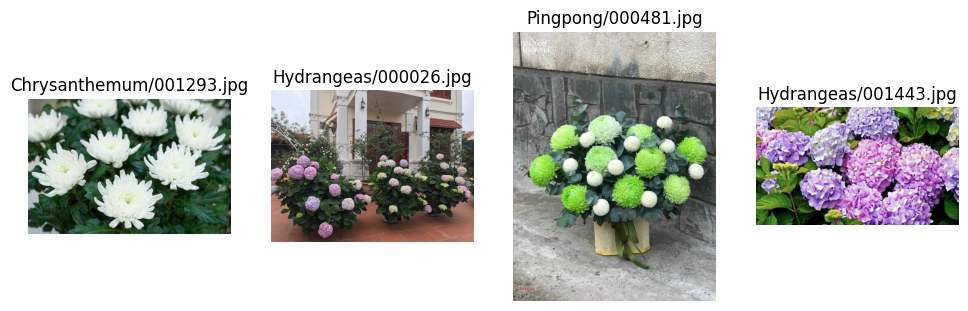

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
for i, path in enumerate(df_sample_ref_img_paths):
    with Image.open(f'{dir_raw_dataset}{path}') as ref:
        ax[i].imshow(ref)
        ax[i].set_title(path, fontsize=12)
        ax[i].axis('off')

plt.show()

### 5.4.2. Load saved Feature Extractor and Clustering Models

In [5]:
fe = tf.keras.models.load_model(path_model_feature_extractor)
clu = joblib.load(path_model_clustering)

In [6]:
fe.summary()

Model: "fe-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      32832     
                                                                 
 average_pooling2d (AverageP  (None, 61, 61, 64)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 238144)            0         
                                                                 
 dense (Dense)               (None, 128)               30482

In [7]:
print(clu)

KMeans(n_init='auto')


### 5.4.3. Load Recommender Database

In [8]:
df_rec = pd.read_csv(path_recommender_database)

In [9]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4685 entries, 0 to 4684
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ImgPath  4685 non-null   object 
 1   Class    4685 non-null   object 
 2   x0       4685 non-null   float64
 3   x1       4685 non-null   float64
 4   x2       4685 non-null   float64
 5   x3       4685 non-null   float64
 6   x4       4685 non-null   float64
 7   x5       4685 non-null   float64
 8   x6       4685 non-null   float64
 9   x7       4685 non-null   float64
 10  x8       4685 non-null   float64
 11  x9       4685 non-null   float64
 12  x10      4685 non-null   float64
 13  x11      4685 non-null   float64
 14  x12      4685 non-null   float64
 15  x13      4685 non-null   float64
 16  x14      4685 non-null   float64
 17  x15      4685 non-null   float64
dtypes: float64(16), object(2)
memory usage: 659.0+ KB


### 5.4.4. Classify and Recommend

In [10]:
num_recommendations = 10  # Will be provided by the user in the client code
k = int(np.sqrt(len(df_rec) / num_recommendations))
clu.set_params(n_clusters=k)

KMeans(n_clusters=21, n_init='auto')

In [75]:
results = []
for path in df_sample_ref_img_paths:
    with Image.open(f'{dir_raw_dataset}{path}') as ref:
        # Classify reference image
        ref_processed, ref_class = classify(f'{dir_raw_dataset}{path}', classifier_path=path_model_clf, return_original=False)
        recommendations = df_rec[df_rec['Class'] == ref_class]

        # Extract reference image feature vector
        ref_processed = np.squeeze(ref_processed)
        ref_feature_vector = fe.predict(
            tf.expand_dims(ref_processed, axis=0),
            verbose=0
        )
        ref_feature_vector = ref_feature_vector.astype(float)
        ref_feature_vector = ref_feature_vector.reshape(1, -1)

        # Cluster reference image
        clu.fit(recommendations.drop(['ImgPath', 'Class'], axis='columns').values)
        ref_cluster = clu.predict(ref_feature_vector)
        ref_cluster_indices = np.where(clu.labels_ == ref_cluster)
        recommendations = recommendations.iloc[ref_cluster_indices]

        # Rank cluster and produce top cosine similarity recommendations
        cosine_similarities = cosine_similarity(ref_feature_vector, recommendations.drop(['ImgPath', 'Class'], axis='columns'))
        sorted_ref_cluster_indices = ref_cluster_indices[0][np.argsort(-cosine_similarities.flatten())]
        top_ref_cluster_indices = sorted_ref_cluster_indices[:num_recommendations]
        print(recommendations)
        print(top_ref_cluster_indices)
        recommendations = recommendations.iloc[top_ref_cluster_indices]

        results.append(recommendations['ImgPath'])
print(results)

                            ImgPath       Class         x0         x1   
2706          Lisianthus/000015.jpg  Lisianthus  59.449800   0.292227  \
2740          Lisianthus/000050.jpg  Lisianthus  61.483257  25.041798   
2750          Lisianthus/000060.jpg  Lisianthus  49.675080   2.048975   
2787    Lisianthus/lisianthus_1.jpg  Lisianthus  42.328407  27.509827   
2809  Lisianthus/lisianthus_119.jpg  Lisianthus  41.628258   3.968022   
2842  Lisianthus/lisianthus_150.jpg  Lisianthus  57.206940  -2.900765   
2843  Lisianthus/lisianthus_151.jpg  Lisianthus  42.315716   0.168171   
2863  Lisianthus/lisianthus_189.jpg  Lisianthus  39.182390  -2.013983   
2877   Lisianthus/lisianthus_21.jpg  Lisianthus  41.578552 -10.031698   
2901  Lisianthus/lisianthus_252.jpg  Lisianthus  39.191784  -8.247929   
2923  Lisianthus/lisianthus_278.jpg  Lisianthus  44.974163 -12.565738   
2924  Lisianthus/lisianthus_279.jpg  Lisianthus  51.696526   1.107911   
2926  Lisianthus/lisianthus_280.jpg  Lisianthus  33

IndexError: positional indexers are out-of-bounds